In [20]:
import eli5
from eli5.sklearn import PermutationImportance
from keras.layers import Dense
from keras.models import Sequential
from keras.optimizers import Adam
from keras.wrappers.scikit_learn import KerasRegressor
import missingno
import numpy as np
import pandas as pd
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf

class TFModel:
    def _create_layer(self, input_layer, layer_weights, layer_bias, activation_func):
        layer = tf.add(tf.matmul(input_layer, layer_weights), layer_bias)
        return activation_func(layer)
    
    def __init__(self, num_inputs, num_outputs, hidden_layer_sizes):
        self.num_inputs = num_inputs
        self.num_outputs = num_outputs
        
        layer_sizes = [self.num_inputs] + hidden_layer_sizes + [self.num_outputs]
        num_layers = len(layer_sizes)
        
        weights = list(
            map(
                lambda input_size, output_size: tf.Variable(
                    tf.random_normal(shape=[input_size, output_size])
                ),
                layer_sizes,
                layer_sizes[1:],
            )
        )
        
        biases = list(
            map(
                lambda layer_size: tf.Variable(tf.random_normal(shape=[layer_size])),
                layer_sizes[1:],
            )
        )
        
        activation_funcs = list(
            map(
                lambda layer_index: tf.identity
                if layer_index == num_layers - 2
                else tf.nn.relu,
                range(num_layers - 1),
            )
        )
        
        self._input = tf.placeholder(shape=[None, self.num_inputs], dtype=tf.float32)
        layer = self._input
        for layer_weights, layer_bias, activation_func in zip(
            weights, biases, activation_funcs
        ):
            layer = self._create_layer(
                layer, layer_weights, layer_bias, activation_func
            )
        
        self._output = layer
        
        self._target_output = tf.placeholder(
            shape=[None, self.num_outputs], dtype=tf.float32
        )
        loss = tf.losses.mean_squared_error(self._target_output, self._output)
        self._optimizer = tf.train.AdamOptimizer().minimize(loss)
        
        self.init = tf.global_variables_initializer()
    
    def predict(self, sess, input):
        return sess.run(self._output, feed_dict={self._input: input})

    def predict_batch(self, sess, inputs):
        return sess.run(self._output, feed_dict={self._input: inputs})

    def train_batch(self, sess, inputs, outputs):
        sess.run(
            self._optimizer,
            feed_dict={self._input: inputs, self._target_output: outputs},
        )
        
def build_keras_model_func(input, output, number_of_nodes_in_hidden_layer=3, number_of_hidden_layers=2, hidden_layer_activation='relu', output_layer_activation='linear', loss='mse'):
    def func():
        model = Sequential()
        model.add(Dense(number_of_nodes_in_hidden_layer, activation=hidden_layer_activation, input_shape=(len(input.columns),)))
        for _ in range(number_of_hidden_layers - 1):  
            model.add(Dense(number_of_nodes_in_hidden_layer, activation=hidden_layer_activation))
        model.add(Dense(1, activation=output_layer_activation))

        adam = Adam(lr=0.01)
        model.compile(loss=loss, optimizer=adam, metrics=['acc'])
        
        return model
    
    return func

# find outliers using Isolation Forest
def find_outliers_isolation_forest(dataframe):
    isolation_forest = IsolationForest(contamination='auto', behaviour='new')
    isolation_forest.fit(dataframe)
    return isolation_forest.predict(dataframe)

   max_temperature_f  mean_temperature_f  min_temperature_f  max_dew_point_f  \
0           0.384210            0.906350           1.261351         1.318208   
1           0.858851            1.047906           1.118872         1.318208   
2           0.028229            0.340127           0.691437         0.659233   
3           0.384210            0.623238           0.833915         1.153465   
4           0.502870            1.047906           1.403829         1.318208   

   mean_dew_point_f  min_dew_point_f  max_humidity  mean_humidity  \
0          1.320862         1.369133      0.978347       0.882042   
1          1.320862         1.369133      0.606059       0.352357   
2          1.029792         1.129367      0.978347       0.882042   
3          1.029792         1.009484      0.233772       0.140482   
4          1.611932         1.608899      0.978347       1.093916   

   min_humidity  max_sea_level_pressure_inches  ...  Holiday_Independence Day  \
0      0.802169        

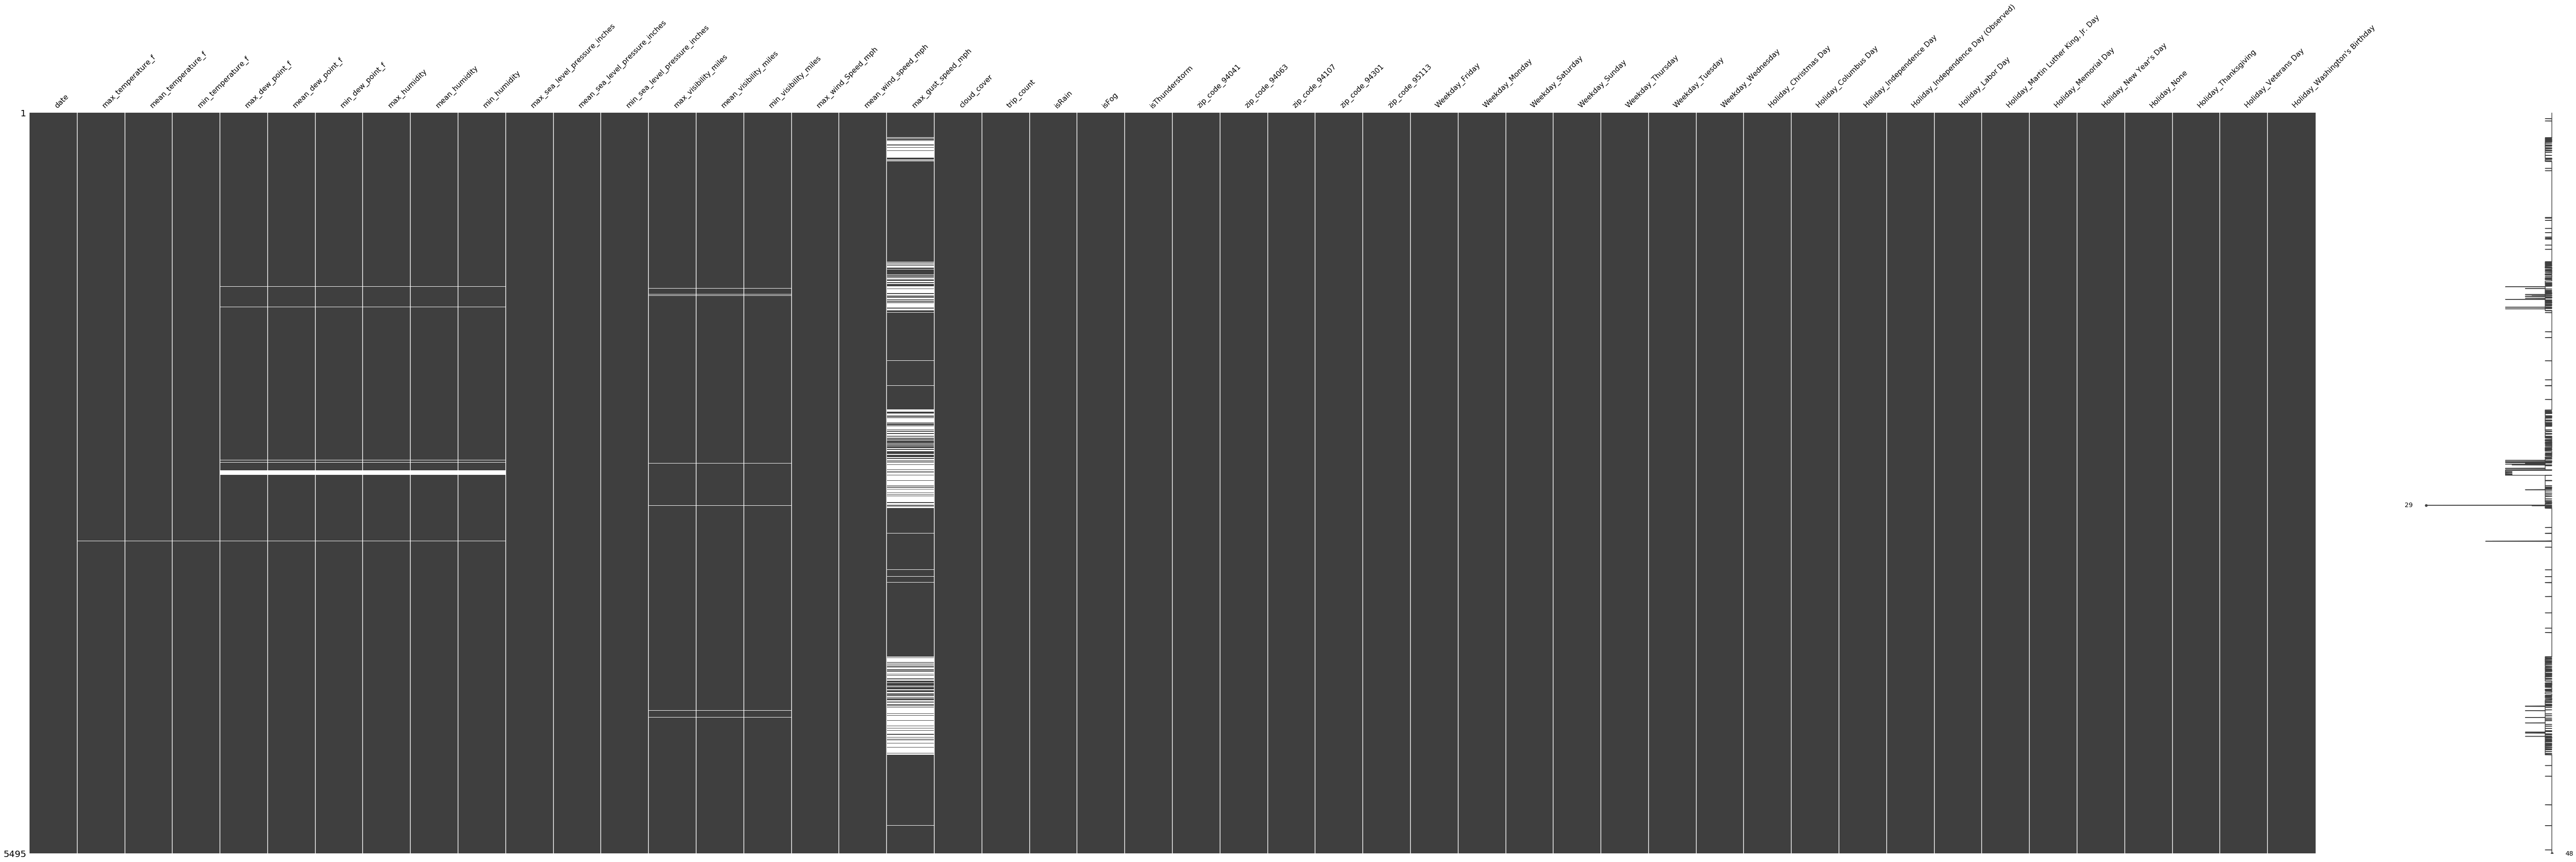

In [26]:
data = pd.read_csv("dataset/yes_date_set.csv")
missingno.matrix(data, figsize=(100, 30))
data = data.dropna()
data = data.drop('date', axis=1)

# find outliers using Isolation Forest
outliers_isolation = find_outliers_isolation_forest(data)
data.insert(0, "outliers_isolation", outliers_isolation, True)

# drop outliers based on Isolation Forest method
data = data.drop(data[data.outliers_isolation == -1.0].index)
data = data.drop('outliers_isolation', axis=1)

X = data.drop(['trip_count'], axis=1)
y = data[['trip_count']]

# normalize input
standard_scaler = StandardScaler()
X = pd.DataFrame(standard_scaler.fit_transform(X),columns=X.columns)

print(X.head())
print(y.head())

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=50)

In [27]:
model = TFModel(len(X.columns), 1, [3, 3])
with tf.Session() as sess:
    sess.run(model.init)
    
    model.train_batch(sess, X, y)
    predictions = model.predict_batch(sess, X)
    print(predictions)

[[3.7595675]
 [2.2571034]
 [2.8785393]
 ...
 [1.8101485]
 [1.1241338]
 [0.926144 ]]


In [ ]:
def grid_search(X_train, y_train, X_test, y_test):
    # perform grid search using multiple number of layers and nodes
    grid = pd.DataFrame(index=np.arange(3), columns=np.arange(4))

    # 1-3 hidden layers
    for i in range(0, 4):
        num_hidden_layers = i + 1

        # 3, 6, 9, or 12 nodes
        for j in range(0, 5):
            num_nodes = j * 3 + 3
            
            # create and fit model with this number of layers/nodes
            func = build_keras_model_func(X_train, y_train, number_of_nodes_in_hidden_layer=num_nodes, number_of_hidden_layers=num_hidden_layers)
            model = func()
            model.fit(X_train, y_train, epochs=150, batch_size=32, verbose=0)
            
            # store testing error of model
            testing_error = model.evaluate(X_test, y_test, batch_size=32)
            grid[i][j] = 1.0 - testing_error[1]
    
    return grid

grid_search(X_train, y_train, X_test, y_test)

In [30]:
func = build_keras_model_func(X, y)
reg = KerasRegressor(build_fn=func, batch_size=32, epochs=100, validation_data=(X_test, y_test), verbose=1)
reg.fit(X_train, y_train)

Train on 2674 samples, validate on 1147 samples
Epoch 1/100
2674/2674 [==============================] - 0s 175us/step - loss: 212362.9256 - acc: 0.0176 - val_loss: 204926.2811 - val_acc: 0.0201
Epoch 2/100
2674/2674 [==============================] - 0s 78us/step - loss: 131415.5313 - acc: 0.0116 - val_loss: 59825.3351 - val_acc: 0.0061
Epoch 3/100
2674/2674 [==============================] - 0s 89us/step - loss: 33829.1636 - acc: 0.0086 - val_loss: 22980.6962 - val_acc: 0.0131
Epoch 4/100
2674/2674 [==============================] - 0s 98us/step - loss: 14062.1286 - acc: 0.0112 - val_loss: 12408.0634 - val_acc: 0.0166
Epoch 5/100
2674/2674 [==============================] - 0s 86us/step - loss: 8420.4931 - acc: 0.0123 - val_loss: 9380.9149 - val_acc: 0.0139
Epoch 6/100
2674/2674 [==============================] - 0s 86us/step - loss: 6860.0110 - acc: 0.0165 - val_loss: 7997.2813 - val_acc: 0.0166
Epoch 7/100
2674/2674 [==============================] - 0s 84us/step - loss: 6136.9286 

In [37]:
test_predict = reg.predict(X_test)
ylist = y_test["trip_count"].tolist()

for i in range(len(ylist)):
    # y actual vs y predicted
    print(str(ylist[i]), "  ", str(test_predict[i]))

c = 0
for i in range(len(ylist)):
    #print(ylist[i]-test_predict[i])
    c = c + ylist[i]-test_predict[i]
print("============")
#printing if we were short or over the amount of bikes we need
# if negative we have predicted more bikes than we actually need
print(c)
print("============")
c = 0
for i in range(len(ylist)):
    #adding up the total amount of trips taken
    c = c + ylist[i]
print("============")
print(c)
print("============")

1147/1147 [==============================] - 0s 59us/step
35    16.352718
8    16.352718
19    16.352718
1    16.352718
1106    940.0209
10    16.352718
34    24.30693
18    16.352718
35    16.352718
32    16.352718
42    38.215775
73    47.287094
21    16.352718
31    17.807362
1157    1088.708
14    16.352718
5    16.352718
55    16.352718
15    16.352718
1235    1138.93
13    16.352718
48    42.5912
20    16.352718
1184    963.8406
1089    1115.424
43    16.352718
546    711.49
10    16.352718
16    16.352718
24    16.352718
63    53.456444
6    16.352718
614    398.44922
1162    1218.9003
0    16.352718
19    16.352718
835    881.36694
14    16.352718
66    78.10768
1232    1056.7181
56    40.30476
63    43.16372
1196    1039.163
18    16.352718
12    16.352718
28    16.352718
797    1209.7026
27    16.352718
10    16.352718
24    49.24685
27    16.352718
1072    1202.4044
19    16.352718
71    49.040955
44    17.761608
430    341.1804
57    49.42328
5    16.352718
3    16.352718
1

32    16.352718
3    16.352718
43    16.352718
5    16.352718
7    16.352718
307    399.58078
0    16.352718
17    16.352718
11    16.352718
46    55.801083
839    764.35864
21    16.352718
362    386.16833
48    16.352718
6    16.352718
39    40.94073
11    16.352718
1306    1218.6411
16    16.352718
1009    927.55396
34    77.050896
70    70.781784
969    1110.3231
36    47.723392
44    16.352718
6    16.352718
238    334.11063
77    82.52725
347    370.69974
701    900.3788
312    323.048
78    69.20618
45    16.352718
38    16.352718
6    16.352718
242    422.38812
28    16.352718
57    51.969975
11    16.352718
5    16.352718
2    16.352718
46    16.352718
1025    843.4927
54    124.12611
16    16.352718
290    301.40237
3    16.352718
7    16.352718
20    16.352718
13    16.352718
33    42.36528
6    16.352718
29    16.352718
1099    1173.9761
1019    1024.5482
2    16.352718
61    49.488396
55    54.739132
387    391.204
58    43.686455
319    892.6874
9    16.352718
56    74.38

In [29]:
perm = PermutationImportance(reg, random_state=32).fit(X_test, y_test)
eli5.show_weights(perm, feature_names=X_test.columns.tolist())

Weight,Feature
82933.3415 ± 3963.9733,zip_code_94107
44836.9693 ± 3263.2612,zip_code_94041
44114.0203 ± 4044.9749,zip_code_95113
26399.2142 ± 4263.6637,zip_code_94063
22109.2562 ± 1710.9539,Weekday_Sunday
18248.7981 ± 3311.6909,Weekday_Saturday
13876.4940 ± 3352.0256,zip_code_94301
4563.9711 ± 3099.4643,Holiday_None
2467.0768 ± 1770.7692,max_visibility_miles
2271.3751 ± 367.6623,Weekday_Tuesday
